In [47]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut

from skopt import gp_minimize
from skopt.space import Real, Integer

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.transformer import WaveletTransformer
from utils.kernels import generalized_cone_kernel

In [48]:
X = np.load('../data/X_regular_reduced.npy')
y = np.load('../data/y_regular_reduced.npy')
groups = np.load('../data/groups_regular_reduced.npy')

In [49]:
def create_kernel(gamma, beta):
    def kernel(X, Y):
        return generalized_cone_kernel(X, Y, gamma, beta)
    return kernel

def objective(params):
    pipeline = Pipeline([
        ('wavelet_transformer', WaveletTransformer(w_list=[int(params[0]), int(params[1])], n_samples=100, n_frequencies=20)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=params[2])),
        ('svm', SVC(probability=True, kernel=create_kernel(params[3], params[4]), C=params[5]))
    ])
    logo = LeaveOneGroupOut()
    cv = logo.split(X, y, groups)
    scores = cross_val_score(pipeline, X, y, cv=cv, groups=groups, scoring='accuracy', n_jobs=-1)
    harmonic_mean = 1 / np.mean(1 / scores)
    return -np.log(harmonic_mean / (1 - harmonic_mean))

search_space = [
    Integer(1, 7000, name='w1'),
    Integer(1, 7000, name='w2'),
    Integer(1, 100, name='n_components'),
    Real(1e-12, 100, name='gamma'),
    Real(1e-12, 100, name='beta'),
    Real(1e-12, 100, name='C')
]

res = gp_minimize(objective, search_space, n_calls=100, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 52.5595
Function value obtained: -0.2719
Current minimum: -0.2719
Iteration No: 2 started. Evaluating function at random point.


KeyboardInterrupt: 

In [ ]:
params = res.x_iters
scores = 1/(1+np.exp(res.func_vals))

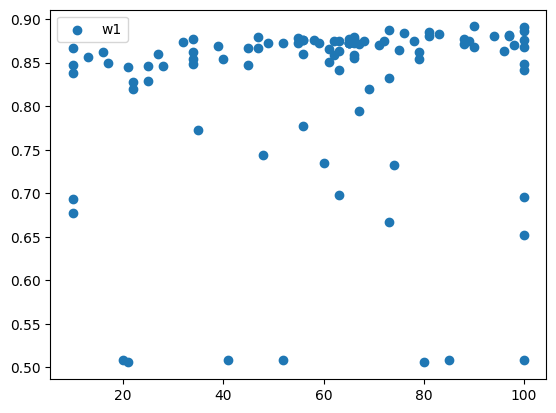

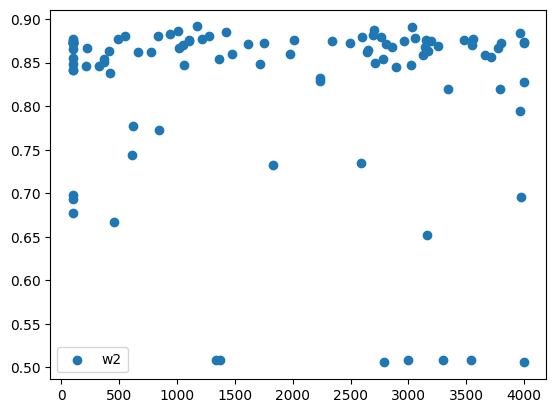

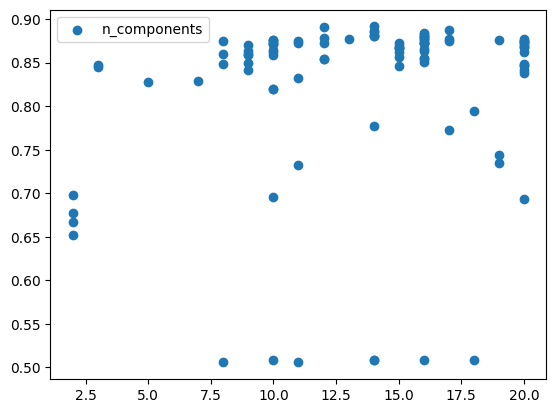

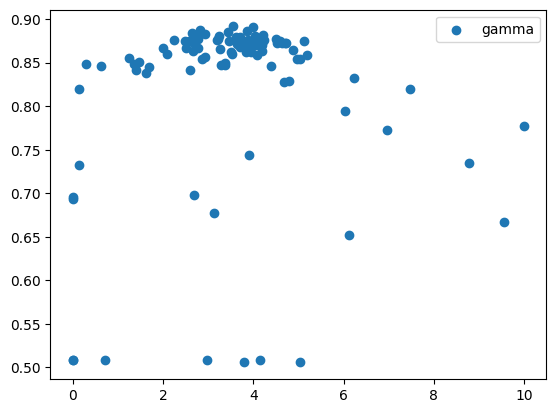

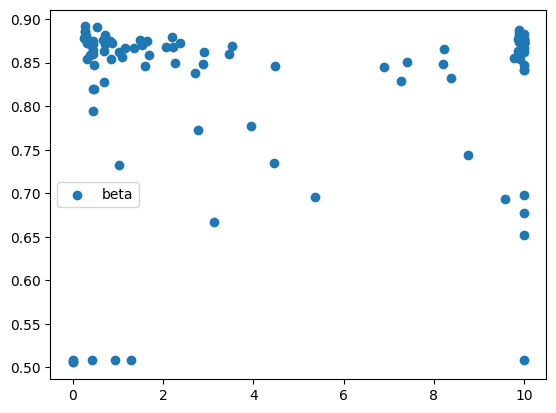

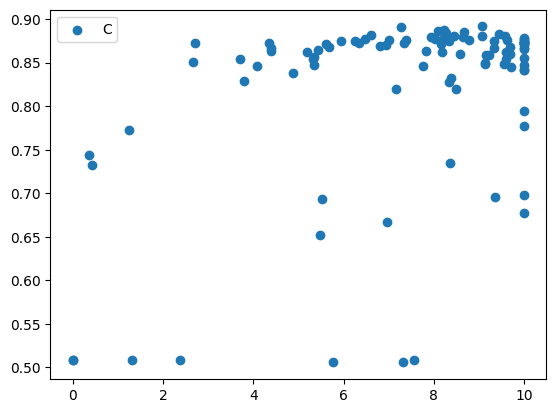

In [ ]:
for i in range(len(search_space)):
    plt.scatter([p[i] for p in params], scores, label=search_space[i].name)
    
    plt.legend()
    plt.show()